In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, \
    accuracy_score
from sklearn.model_selection import KFold

定义逻辑回归类，并封装模型训练和评估接口

In [8]:
class LogisticRegression:
    def __init__(self, iters=50000, alpha=0.004):
        self.iters = iters
        self.alpha = alpha

    #初始数据可视化
    def view(self,path):
        self.data = pd.read_csv(path, names=['Exam 1', 'Exam 2', 'Accepted'])
        fig, ax = plt.subplots()

        # 分为两类点，一类为未被接受的，一类为被接受的
        ax.scatter(self.data[self.data['Accepted'] == 0]['Exam 1'], self.data[self.data['Accepted'] == 0]['Exam 2'],
                   c='r', marker='x',
                   label='y=0')
        ax.scatter(self.data[self.data['Accepted'] == 1]['Exam 1'], self.data[self.data['Accepted'] == 1]['Exam 2'],
                   c='b', marker='o',
                   label='y=1')
        ax.legend()

        ax.set(xlabel='exam1')
        ax.set(ylabel='exam2')
        plt.show()

    def load_data(self, path):
        self.data = pd.read_csv(path, names=['Exam 1', 'Exam 2', 'Accepted'])
        self.data.insert(0, 'ones', 1)
        columns_to_normalize = ['Exam 1', 'Exam 2']
        self.data[columns_to_normalize] = (self.data[columns_to_normalize] - self.data[columns_to_normalize].mean()) / self.data[columns_to_normalize].std()
        self.X, self.y = self.get_Xy(self.data)

    def get_Xy(self, data):
        X_ = data.iloc[:, :-1]
        X = X_.values
        y_ = data.iloc[:, -1]
        y = y_.values.reshape(len(y_), 1)
        return X, y

    def Sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def model(self, X, W):
        return self.Sigmoid(np.dot(X, W.T))

    def costFunction(self, X, y, W):
        A = self.Sigmoid(X @ W)

        first = y * np.log(A)
        second = (1 - y) * np.log(1 - A)

        return -np.sum(first + second) / len(X)

    def gradientDescent(self, X_train, y_train, X_test=None, y_test=None):
        m = len(X_train)
        W = np.zeros((3, 1))
        costs_train = []
        costs_test = []

        for _ in range(self.iters):
            A = self.Sigmoid(X_train @ W)
            W -= (self.alpha / m) * X_train.T @ (A - y_train)
            cost_train = self.costFunction(X_train, y_train, W)
            if X_test is not None and y_test is not None:
                cost_test = self.costFunction(X_test, y_test, W)
                costs_test.append(cost_test)

            costs_train.append(cost_train)

        if X_test is not None and y_test is not None:
            return costs_train, costs_test, W
        else:
            return costs_train, W

    def predict(self, X, W):
        prob = self.Sigmoid(X @ W)
        return [1 if x >= 0.5 else 0 for x in prob]

    def evaluate(self, X_test, y_test, W):
        predictions = self.predict(X_test, W)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        return precision, recall, f1, auc

    #训练及评估
    def cross_validate(self, n_splits=5):
        kf = KFold(n_splits=n_splits) #使用5折交叉验证法
        train_losses = []
        test_losses = []
        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []
        auc_scores = []
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train_idx, test_idx in kf.split(self.X):
            X_train, X_test = self.X[train_idx], self.X[test_idx]
            y_train, y_test = self.y[train_idx], self.y[test_idx]

            costs_train, costs_test, W_final = self.gradientDescent(X_train, y_train, X_test, y_test)

            train_losses.append(costs_train)
            test_losses.append(costs_test)

            predictions = self.predict(X_test, W_final)
            accuracy = accuracy_score(y_test, predictions)
            accuracies.append(accuracy)

            precision, recall, f1, auc = self.evaluate(X_test, y_test, W_final)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            auc_scores.append(auc)

            fpr, tpr, _ = roc_curve(y_test, predictions)
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        mean_train_loss = np.mean(train_losses, axis=0)
        mean_test_loss = np.mean(test_losses, axis=0)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1_score = np.mean(f1_scores)
        mean_auc_score = np.mean(auc_scores)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        #打印评估指标
        print("mean_precision:", mean_precision)
        print("mean_recall:", mean_recall)
        print("mean_f1_score:", mean_f1_score)
        print("mean_auc_score:", mean_auc_score)

        # 绘制训练和测试损失曲线
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(mean_train_loss)), mean_train_loss, label='Train Loss')
        ax.plot(np.arange(len(mean_test_loss)), mean_test_loss, label='Test Loss')
        ax.legend()
        ax.set(xlabel='Iters', ylabel='Loss', title='Training and Testing Loss Curves')
        plt.show()

        # 绘制ROC曲线
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, color='r', lw=2, label=f'ROC curve (area = {mean_auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
        plt.show()

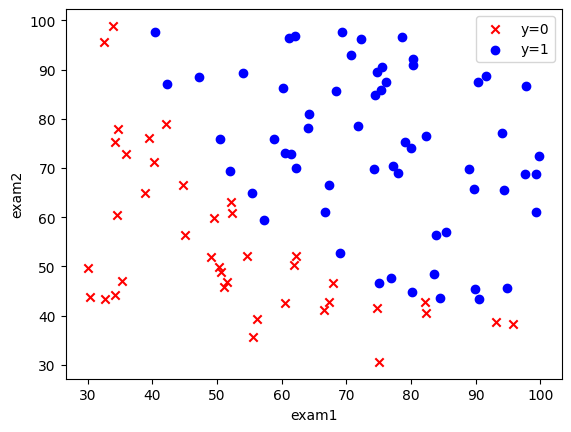

mean_precision: 0.8921356421356421
mean_recall: 0.9181372549019609
mean_f1_score: 0.9020386582726736
mean_auc_score: 0.8937908496732027


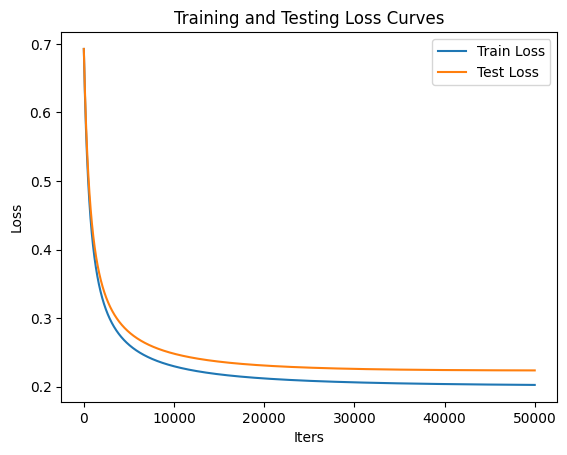

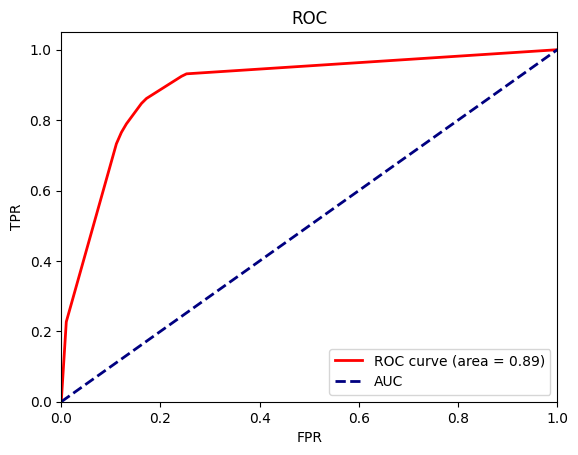

In [9]:
# 使用
model = LogisticRegression()
model.view('D:\\作业\\机器学习\\Homework_02\\ex2data1.txt')
model.load_data('D:\\作业\\机器学习\\Homework_02\\ex2data1.txt')
model.cross_validate()